
# Vector Representations
## *Data Science Unit 4 Sprint 1 Assignment 2*

## 0.1 Get `spacy`

In [1]:
# # Locally (or on colab) let's use en_core_web_lg
!python -m spacy download en_core_web_md # Can do lg, takes awhile
# # Also on Colab, need to restart runtime after this step!

2023-07-28 14:06:13.786517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.10/runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/usr/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/usr/local/lib/python3.10/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.10/dist-packages/spacy/errors.py", line 2, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.10/dis

##0.2 Restart Runtime

## 0.3 Imports

In [2]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_md")

##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [3]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git


Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1742, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 1742 (delta 115), reused 157 (delta 88), pack-reused 1532
Receiving objects: 100% (1742/1742), 60.07 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (284/284), done.


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist"

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar.
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [4]:
data_path = '/content/DS-Unit-4-Sprint-1-NLP/module2-vector-representations/data/job_listings.csv'
df = pd.read_csv(data_path)

In [5]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need!
* Don't spend more time than it takes to figure out how to remove html tags!


In [6]:
def remove_html(text):
    """
    Extract text from html boiler plate code.
    Converts bytes dtype into str dtype

    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/

    Parameters
    ----------
    text: string or object
        contains text data that we want to clean

    Returns
    -------
    text: str
        cleaned text data ready for vectorization
    """

    # create soup object
    soup = BeautifulSoup(text, 'html.parser')

    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string
    #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    text =  eval(soup.get_text())

    # if text is a byte data type, then convert to string
    if isinstance(text, str) == False:

        # convert byte data type into str
        text =  text.decode("utf-8")


    # use regex to clean your text data
    ###BEGIN SOLUTION
    # YOUR CODE HERE
    ###END SOLUTION

    # # case normalize and strip extra white spaces on the far left and right hand side
    # text = re.sub("[^a-zA_Z]", " ", text)


    # return text.lower().lstrip().rstrip()
    # Use regex to clean your text data. Here we are removing anything that is not a word (denoted by \W)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', '', text)

    # case normalize and strip extra white spaces on the far left and right hand side
    text = text.lower().strip()

    return text

In [7]:
df["clean_text"] = df.description.apply(lambda text: remove_html(text))
# would this work? df["clean_text"] = df.description.apply(remove_html)

In [8]:
df.clean_text

0      job requirements  conceptual understanding in ...
1      job description  as a data scientist   you wil...
2      as a data scientist you will be working on con...
3      a monthcontractunder the general supervision o...
4      location  usa   multiple locations   years of ...
                             ...                        
421    about us  want to be part of a fantastic and f...
422    internshipat uber  we ignite opportunity by se...
423    a yeara million people a year die in car colli...
424    senior data scientist job description  about u...
425    cerner intelligence is a new  innovative organ...
Name: clean_text, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [9]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text.
    Token filters are used to exclude low quality tokens.

    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token

    Input
    ----------
    text: string
        raw text document that needs to be tokenized

    Returns
    -------
    tokens: list of strings
    """
    # pass the raw text through the spaCy language model
    doc = nlp(text)

    # # create a list to store the tokens
    # tokens = []

    # for token in doc:
    #   # use the token flas to filter out "low quality" tokens
    #   if (token.is_stop != True) and (token.is_punct != True) and (token.is_space != True):
    #     # return the lemma of the token
    #     tokens.append(token.lemma_)

    # list comprehension
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return tokens

### Apply our tokenizer function via `pandas.apply()`

In [10]:
df["lemmas"] = df.clean_text.apply(tokenizer)

In [11]:
df["lemmas"]

0      [job, requirement, conceptual, understanding, ...
1      [job, description, data, scientist, help, buil...
2      [data, scientist, work, consult, business, res...
3      [monthcontractunder, general, supervision, pro...
4      [location, usa, multiple, location, year, anal...
                             ...                        
421    [want, fantastic, fun, startup, s, revolutioni...
422    [internshipat, uber, ignite, opportunity, set,...
423    [yeara, million, people, year, die, car, colli...
424    [senior, data, scientist, job, description, am...
425    [cerner, intelligence, new, innovative, organi...
Name: lemmas, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix*
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function.

In [12]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL

# Instantiate a CountVectorizer object
vect = CountVectorizer(tokenizer=tokenizer, stop_words="english")

# Use CountVectorizer to create a document-term matrix
dtm_tf = vect.fit_transform(df.clean_text) # Here, tf stands for "term frequency, i.e. counts for each term"

# Convert the document-term matrix into a pandas dataframe
dtm_tf = pd.DataFrame(data=dtm_tf.toarray(), columns=vect.get_feature_names_out())
###END SOLUTION

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
dtm_tf

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich,ﬁeld,ﬁnd,ﬁnding
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts in a barplot

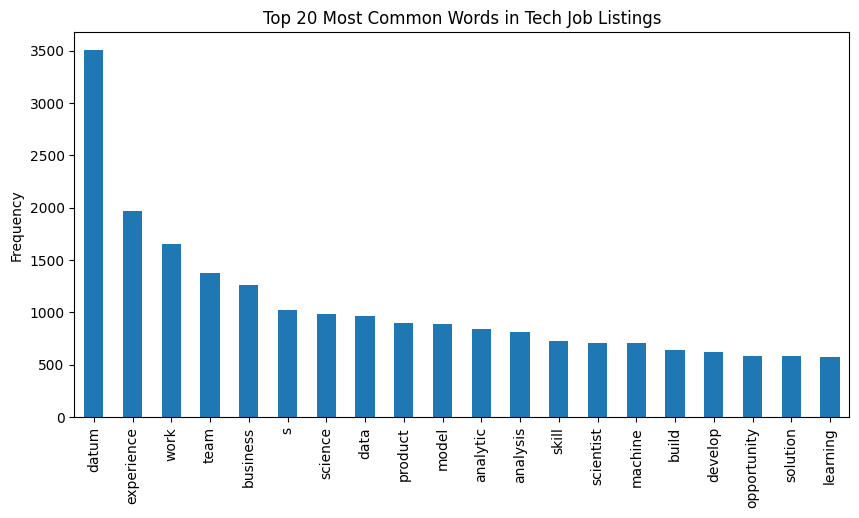

In [14]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tf.sum().sort_values(ascending=False)

# Select the top N terms
top_terms = sorted_terms.head(top_n)

#plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
#sorted_terms[:top_n].plot(kind="bar",figsize(20,8), grid=True, fontsize=14);
# Generate a bar plot
plt.figure(figsize=(10,5))
top_terms.plot(kind='bar')
plt.title(f"Top {top_n} Most Common Words in Tech Job Listings")
plt.ylabel('Frequency')
plt.show()
###END SOLUTION

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a *tf-idf feature matrix*
- Copy your *tf-idf feature matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object

TF-IDF stands for Term Frequency-Inverse Document Frequency, a numerical statistic used to reflect how important a word is to a document in a corpus. It's a common weighting factor in information retrieval and text mining.


In [15]:
%%time
###BEGIN SOLUTION
## YOUR CODE HERE

# Instantiate the tfidfvectorizer
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words="english")

# Fit the tfidVectorizer to the cleaned text
tfidf = tfidf.fit(df.clean_text)

# Transform the cleaned text to get the document term matrix
dtm_tfidf = tfidf.transform(df.clean_text).toarray()

###END SOLUTION

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 1min 31s, sys: 322 ms, total: 1min 31s
Wall time: 1min 32s


In [16]:
# Copy the document-term matrix into a pandas dataframe
dtm_tfidf_df = pd.DataFrame(dtm_tfidf, columns=vect.get_feature_names_out())

In [17]:
dtm_tfidf_df

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich,ﬁeld,ﬁnd,ﬁnding
0,0.0,0.0,0.0,0.0,0.091489,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.021707,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.070185,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.114152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.029438,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.000000,0.067141,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

To visualize the TF-IDF Document-Term matrix, we can use a similar approach as we used before. However, remember that TF-IDF is a bit different from raw term frequency: it gives a higher score to words that are more 'unique' to each document, so the most common words in the corpus might not be the ones with the highest TF-IDF scores.

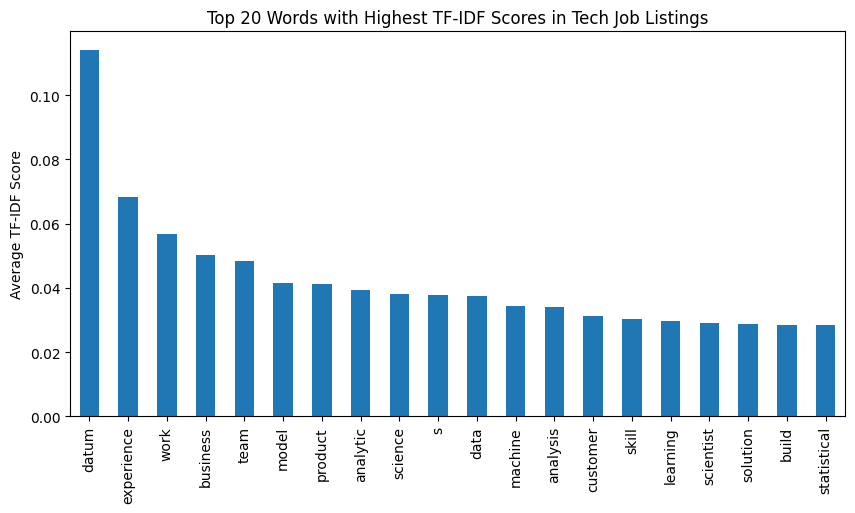

In [18]:
# Calculate the mean TF-IDF score for each term
sorted_terms_tfidf = dtm_tfidf_df.mean().sort_values(ascending=False)

# Select the top N terms
top_terms_tfidf = sorted_terms_tfidf.head(top_n)

# Generate a bar plot
plt.figure(figsize=(10,5))
top_terms_tfidf.plot(kind='bar')
plt.title(f"Top {top_n} Words with Highest TF-IDF Scores in Tech Job Listings")
plt.ylabel('Average TF-IDF Score')
plt.show()


The resulting plot will show the words with the highest average TF-IDF scores in the job listings. This gives us an idea of the words that, according to TF-IDF, are the most 'important' or 'informative' in the corpus.

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [19]:
ideal_ds_job_query=["""
I am seeking a Data Science role in a dynamic and innovative company that values the intersection of health, fitness, and technology.
The ideal position would allow me to leverage my unique blend of experiences as a former professional athlete and prospective data scientist.
I am particularly interested in roles that involve predictive modeling, machine learning, and data-driven insights to enhance human well-being and performance.

In this role, I would like to have the opportunity to work with diverse datasets related to human behavior, performance, and physiology.
I am particularly interested in roles that allow me to apply my skills in Python, machine learning, and data analysis to uncover key insights and drive decision-making processes.

The ideal company would be one that encourages growth and learning, providing opportunities for me to continue honing my skills in data science and machine learning.
I am also looking for a company that values collaboration and teamwork, where I can work closely with a team of passionate and dedicated professionals.

Finally, I am looking for a role that aligns with my personal values and interests in health and fitness.
I am particularly drawn to companies that are at the forefront of combining fitness and technology, and that take a data-driven approach to enhancing human health and performance.

                    """]

In [20]:
# vectorize your ideal job description using your fitted tfidf vectorizer
ideal_job_vector = tfidf.transform(ideal_ds_job_query).toarray()

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
# YOUR CODE HERE#
nn = NearestNeighbors(n_neighbors=10, metric='cosine'
                      )
nn.fit(dtm_tfidf_df)

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [21]:
# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
# YOUR CODE HERE
# Look at a few of the most similar job descriptions to the ideal job
for index in n_ind[0]:
    print(df.iloc[index]['description'])
    print("\n---\n")

b"<div><p>Under Armour is the chosen brand of this generation of athletes... and the athletes of tomorrow. We're about performance - in training and on game day, in blistering heat and bitter cold. Whatever the conditions, whatever the sport, Under Armour delivers the advantage athletes have come to demand.<br/>\nThat demand has created an environment of growth. An environment where building a great team is vital. An environment where doing whatever it takes is the baseline and going above and beyond to protect the Brand is commonplace.<br/>\nThe world's hungriest athletes live by a code, a pledge to themselves and everyone else: Protect This House... I Will. Our goal is to Build A Great Team! <b>Will YOU\xe2\x80\xa6Protect This House?!</b></p><p>\nNo matter what goals today\xe2\x80\x99s athlete has, the Connected Fitness business unit provides the technology needed to help them train, perform, and improve. All they need to bring is the WILL. MapMyFitness, Endomondo, MyFitnessPal and U

In [22]:
count = 0
for most_sim_job_index in n_ind[:][0]:
  most_sim_job = df.clean_text.iloc[most_sim_job_index]
  count += 1
  print("\n", count," ", most_sim_job)


 1   under armour is the chosen brand of this generation of athletes    and the athletes of tomorrow  we re about performance   in training and on game day  in blistering heat and bitter cold  whatever the conditions  whatever the sport  under armour delivers the advantage athletes have come to demand  that demand has created an environment of growth  an environment where building a great team is vital  an environment where doing whatever it takes is the baseline and going above and beyond to protect the brand is commonplace  the world s hungriest athletes live by a code  a pledge to themselves and everyone else  protect this house    i will  our goal is to build a great team  will you protect this house   no matter what goals today s athlete has  the connected fitness business unit provides the technology needed to help them train  perform  and improve  all they need to bring is the will  mapmyfitness  endomondo  myfitnesspal and under armour have teamed up to create under armour con

## Stretch Goals: do one of more of these that strike your fancy!

 - Repeat Part 6, but this time using spacy's word embeddings to represent documents as vectors. Remember, to form a document vector from spacy word embeddings, you average together the word embedding vectors of all the words in the document, so the document vector will have the same dimensionality as the word embeddings, namely 300 dimensions. Do you notice any difference in the results?
 - Watch Josh Starmer's video [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ). Or read [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en) on Singular Value Decomposition (SVD). Now go back and review the section "Can we visualize word vectors?" from the [lecture video](https://drive.google.com/file/d/1QuwkO2Uj5sONFtqCk0_d2zrks2I6stkN/view?usp=sharing). Write a brief description of your understanding of Principal Components Analysis, and how it was used to visualize word vectors. Do your own experiments to explore relationships of words in two dimensions. Write a summary of what you discovered.

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings?
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. Hint: compose a query that references a number of tech stack items. How are those items distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this; algorithms that depend on Euclidean distance break down with high dimensional data. Do a bit of research to see if you can identify a suitable clustering algorithm.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for.


---



To use Spacy's word embeddings to represent documents as vectors, we first need to load a pre-trained language model from Spacy. The language model has word embeddings pre-trained on a large corpus of text.

In the case of English, the language model is trained on a large portion of the internet and includes word vectors for over 20,000 common words. Each word is represented as a 300-dimensional vector.

We can then use these word vectors to compute a document vector for each job description. The document vector is simply the average of the word vectors for all words in the document.

Once we have these document vectors, we can use them to fit a Nearest Neighbors model, just like we did with the TF-IDF vectors.

Here is a rough outline of how to do this:

In [24]:
# Load the pre-trained language model from Spacy
#nlp = spacy.load('en_core_web_md')

# Calculate document vectors for job descriptions
doc_vectors = df['description'].apply(lambda x: nlp(x).vector)

# Convert series of lists to 2D array
doc_vectors = np.array([np.array(xi) for xi in doc_vectors])

# Fit a NearestNeighbors model to the document vectors
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(doc_vectors)

# Calculate the document vector for the ideal job description
ideal_job_vector = nlp(ideal_ds_job_query[0]).vector

# Get the top 5 nearest neighbors
n_dist, n_ind = nn.kneighbors([ideal_job_vector])

# Look at a few of the most similar job descriptions to the ideal job
for index in n_ind[0]:
    print(df.iloc[index]['description'])
    print("\n---\n")


b"<div><div><div>We believe that a great writing experience is fast, outcome-focused, and alive with your ideas. Going from start to finish on a document in three minutes. Knowing who will respond to anything you've written before you even press send. Writing software that puts your ideas at the center, with language that is certain to land the way you want. Textio has already changed the way that thousands of companies write and now we are looking for a creative and curious data scientist with a passion for modeling to join us.</div><div><br/>\n</div><div>\nIn this role you will help us improve the quality of Textio's current genre-defining models and you will create the new models that will power Textio's future products. You will work with a top-notch team of data scientists, engineers, product managers, and others to turn Textio's rich linguistic data into user-facing products that provide a unique balance of predictive power, model introspection, and user guidance. Your influence 

As for the results, you might find that the word embeddings give you different nearest neighbors than the TF-IDF vectors. This is because word embeddings capture more semantic information than TF-IDF. For example, words that are used in similar contexts will have similar word vectors, even if they don't have similar TF-IDF scores. This can lead to more meaningful similarities between documents.